In [2]:
from sirf.STIR import (ImageData, AcquisitionData,
                       SPECTUBMatrix, AcquisitionModelUsingMatrix,
                       make_Poisson_loglikelihood, OSMAPOSLReconstructor,
                       SeparableGaussianImageFilter, MessageRedirector,
                       FBP2DReconstructor,
)
from simind import *
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
current_directory = os.getcwd()
current_directory

'/home/sam/working/STIR_users_MIC2023'

In [4]:
msg = MessageRedirector()
AcquisitionData.set_storage_scheme('memory')

In [5]:
# SIMIND parameters
total_activity = 187 # MBq
time_per_projection = 60 # seconds
photon_multiplier = 0.01
photopeak_energy =  150 # keV
window_lower = 75 # keV
window_upper = 225 # keV
source_type = "y90_tissue" 
collimator = 'ma-megp'
kev_per_channel = 5
num_energy_spectra_channels = 400

# OSEM parameters
iterations = 5
subsets = 12

In [6]:
template_image = ImageData("/home/sam/data/phantom_data/SPECT/NEMA_SPECT_template.hv")
mu_map = ImageData("/home/sam/data/phantom_data/SPECT/spect_attn.hv")

measured_data = AcquisitionData("/home/sam/data/phantom_data/SPECT/peak_1_projdata__f1g1d0b0.hs")

In [7]:
mu_map_stir = mu_map.clone()
mu_map_stir.fill(np.flip(mu_map_stir.as_array(), axis=2))

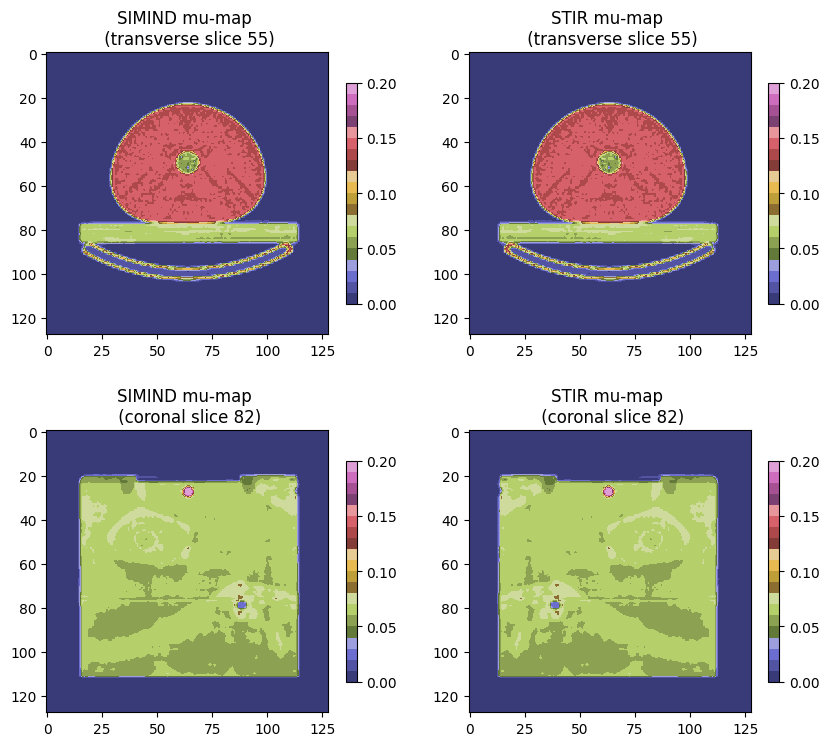

In [8]:
axial_slice = 55
coronal_slice = 82

vmax = 0.20

fig, ax = plt.subplots(2, 2, figsize=(10, 9))
ax0 = ax[0,0].imshow(mu_map.as_array()[axial_slice, :, :], cmap='tab20b', vmax=vmax)
ax[0,0].set_title(f"SIMIND mu-map \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax[0,0], shrink=0.7)
ax1 = ax[0,1].imshow(mu_map_stir.as_array()[axial_slice, :, :], cmap='tab20b', vmax=vmax)
ax[0,1].set_title(f"STIR mu-map \n (transverse slice {axial_slice})")
fig.colorbar(ax1, ax=ax[0,1], shrink=0.7)
ax2 = ax[1,0].imshow(mu_map.as_array()[:, coronal_slice, :], cmap='tab20b', vmax=vmax)
ax[1,0].set_title(f"SIMIND mu-map \n (coronal slice {coronal_slice})")
fig.colorbar(ax2, ax=ax[1,0], shrink=0.7)
ax3 = ax[1,1].imshow(mu_map_stir.as_array()[:, coronal_slice, :], cmap='tab20b', vmax=vmax)
ax[1,1].set_title(f"STIR mu-map \n (coronal slice {coronal_slice})")
fig.colorbar(ax3, ax=ax[1,1], shrink=0.7)

In [9]:
acq_matrix = SPECTUBMatrix()
acq_matrix.set_attenuation_image(mu_map_stir)
acq_matrix.set_keep_all_views_in_cache(True)
acq_matrix.set_resolution_model(1.81534, 0.02148, False)
acq_model = AcquisitionModelUsingMatrix(acq_matrix)
acq_model.set_up(measured_data, template_image)

In [10]:
def divide(a,b, eps=1e-8):
    return (a+eps)/(b+eps) 

def osem_step(acq_model, acq_data, current_image, sensitivity_image, scatter):
    fp = acq_model.forward(current_image) + scatter
    bpr = acq_model.backward(divide(acq_data, fp))
    return divide(current_image * bpr, sensitivity_image)

def run_osem(acq_model, acq_data, initial_image, iterations, subsets, scatter = 0):
    current_image = initial_image.clone()
    sensitivity_images = []
    one_sino = acq_data.get_uniform_copy(1)
    for i in range(iterations):
        for s in range(subsets):
            acq_model.subset_num = s
            if len(sensitivity_images) < subsets:
                sensitivity_images.append(acq_model.backward(one_sino))
            current_image = osem_step(acq_model, acq_data, current_image, sensitivity_images[s], scatter)
            print(f"Completed iteration {i+1} of {iterations}, subset {s+1} of {subsets}")
    return current_image

In [11]:
acq_model.num_subsets = subsets

osem_reconstruction = run_osem(acq_model, measured_data, template_image.get_uniform_copy(1), iterations, subsets)

backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 1 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 2 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 3 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 4 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 5 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 6 of 12
backprojecting...ok
no additive term added
no unnorm

In [12]:
osem_reconstruction_postfilter = osem_reconstruction.clone()

gaussian_filter = SeparableGaussianImageFilter()
gaussian_filter.set_fwhms((5, 5, 5))
gaussian_filter.apply(osem_reconstruction_postfilter)

osem_reconstruction_postfilter_array = osem_reconstruction_postfilter.as_array()
osem_reconstruction_postfilter_array[osem_reconstruction_postfilter_array < 0.1 * osem_reconstruction_postfilter.max()] = 0
osem_reconstruction_postfilter.fill(osem_reconstruction_postfilter_array)

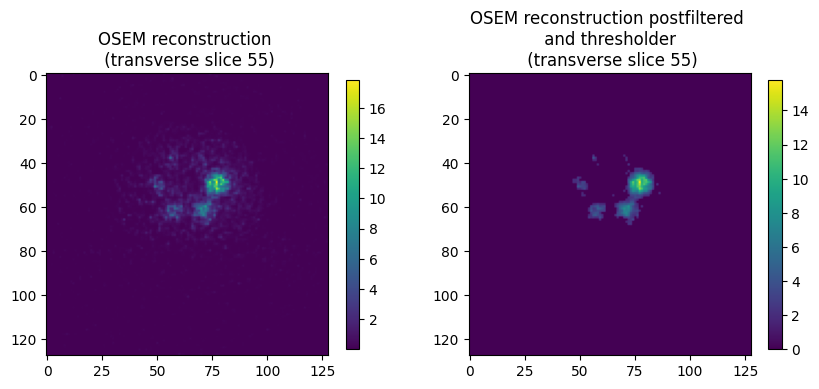

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax0 = ax[0].imshow(osem_reconstruction.as_array()[axial_slice, :, :])
ax[0].set_title(f"OSEM reconstruction \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax[0], shrink=0.7)
ax1 = ax[1].imshow(osem_reconstruction_postfilter.as_array()[axial_slice, :, :])
ax[1].set_title(f"OSEM reconstruction postfiltered \n and thresholder \n (transverse slice {axial_slice})")
fig.colorbar(ax1, ax=ax[1], shrink=0.7)

In [14]:
create_window_file(lower_bounds=window_lower, upper_bounds=window_upper, scatter_orders=0, output_filename= "input.win")

In [15]:
simulator = SimindSimulator(input_filepath=".", output_filepath=".",)
attributes = {"SourceMap": osem_reconstruction_postfilter,
              "MuMap": mu_map,
              "keVPerChannel": kev_per_channel, 
              'NumberOfEnergySpectraChannels': num_energy_spectra_channels,
              "PhotopeakEnergy": photopeak_energy,
              "SourceActivity": total_activity,
              "PhotonMultiplier": photon_multiplier,
              "ImageDurationPerProjection": time_per_projection,
              "SourceType": source_type.lower(),
              "Collimator": collimator,}
simulator.set_template_sinogram(measured_data)
simulator.set_attributes(attributes)

In [16]:
simulator.run_simulation()

Clearing all files in . that could cause trouble...
This includes:
 - .h00, .hs, .a00, .hct, .ict, .bis, .res
if this is not what you want, please cancel this process now.
5
4
3
2
1
removed output_air_w1.a00
removed output.res
removed output_air_w1.h00
removed output_tot_w1.h00
removed output.bis
removed output_tot_w1.hs
removed output_sca_w1.h00
removed tmp_adjus_adjusted.h00
removed output_sca_w2.h00
removed tmp.hs
removed output_sca_w2.hs
removed output_sca_w2.a00
removed output_tot_w1.a00
removed output_sca_w1.a00
removed output_air_w1.hs
removed output_sca_w1.hs
All required attributes are set and ready for simulation.
All relevant files exist in ..
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists



              SIMIND Monte Carlo Si

In [17]:
simind_total = simulator.get_output_total()
simind_scatter = simulator.get_output_scatter()
simind_true = simind_total - simind_scatter

Output in ./output_air_w1.hs

Output in ./output_tot_w1.hs

Output in ./output_sca_w1.hs

Output in ./output_sca_w2.hs






In [18]:
stir_projection = measured_data.get_uniform_copy(0)
for i in range(subsets):
    acq_model.subset_num = i
    stir_projection+=acq_model.forward(osem_reconstruction_postfilter)

measured_counts = measured_data.sum()
simind_counts = simind_total.sum()

#simind_true*= measured_counts/simind_counts
#simind_total*= measured_counts/simind_counts
#simind_scatter*= measured_counts/simind_counts

no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added


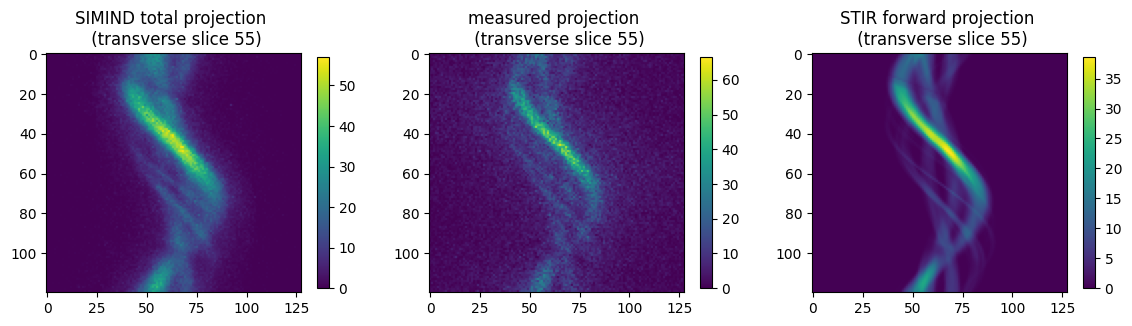

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax0 = ax[0].imshow((simind_total).as_array()[0,axial_slice, :, :])
ax[0].set_title(f"SIMIND total projection \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax[0], shrink=0.6)
ax1 = ax[1].imshow(measured_data.as_array()[0,axial_slice, :, :])
ax[1].set_title(f"measured projection \n (transverse slice {axial_slice})")
fig.colorbar(ax1, ax=ax[1], shrink=0.6)
ax2 = ax[2].imshow(stir_projection.as_array()[0,axial_slice, :, :])
ax[2].set_title(f"STIR forward projection \n (transverse slice {axial_slice})")
fig.colorbar(ax2, ax=ax[2], shrink=0.6)

In [20]:
print(f"SIMIND total counts: {simind_total.sum()}")
print(f"SIMIND true counts: {simind_true.sum()}")
print(f"Measured counts: {measured_data.sum()}")
print(f"STIR forward projection counts: {stir_projection.sum()}")

SIMIND total counts: 1503076.5
SIMIND true counts: 377004.5625
Measured counts: 4140417.75
STIR forward projection counts: 225023.5


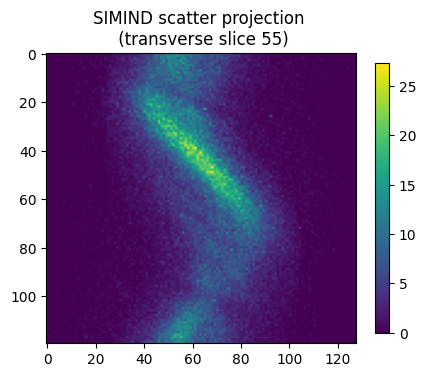

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax0 = ax.imshow(simind_scatter.as_array()[0,axial_slice, :, :])
ax.set_title(f"SIMIND scatter projection \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax, shrink=0.7)


In [22]:
osem_reconstruction_with_simind_scatter_correction = run_osem(acq_model, measured_data, template_image.get_uniform_copy(1), iterations, subsets, scatter = simind_scatter)

backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 1 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 2 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 3 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 4 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 5 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 6 of 12
backprojecting...ok
no additive term added
no unnorm

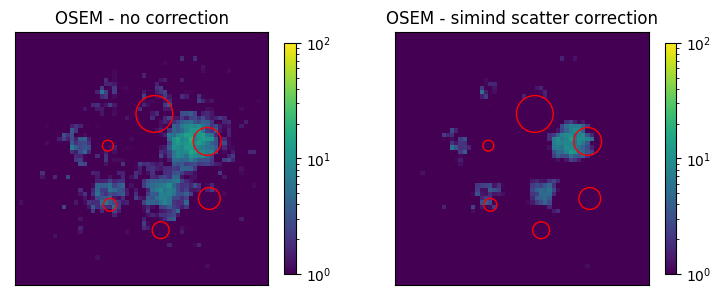

In [41]:
from matplotlib.colors import LogNorm

# round osem_max up to the nearest power of 10
osem_max = 10 ** np.ceil(np.log10(osem_reconstruction.max()))

# Lu177 [65, 40:104, 32:96]

slice = 55

# same as above but highlight lower values with inverse log scale
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax0 = ax[0].imshow(osem_reconstruction.as_array()[slice, 24:84, 36:96], norm=LogNorm(vmin=1, vmax=osem_max))
ax[0].set_title("OSEM - no correction")
ax1 = ax[1].imshow(osem_reconstruction_with_simind_scatter_correction.as_array()[slice, 24:84, 36:96], norm=LogNorm(vmin=1, vmax=osem_max))
ax[1].set_title("OSEM - simind scatter correction")
fig.colorbar(ax0, ax=ax[0], shrink=0.6)
fig.colorbar(ax1, ax=ax[1], shrink=0.6)


# draw spheres on images to show where the spheres are
# sphere diams are 60, 37, 28, 22, 17, 13 mm
from matplotlib.patches import Circle

# sphere centres in pixels - Tc99m
centres = [(32.5, 19), (45, 25.5), (45.5, 39), (34, 46.5), (22, 40.5), (21.5, 26.5)]
# sphere radii in pixels
pixel_size = osem_reconstruction.voxel_sizes()[0]
diams = [37, 28, 22, 17, 13, 11]
diam_bg = 50
centre_bg = (32.5, 32.5)
radii = [r / pixel_size /2 for r in diams]
radius_bg = diam_bg / pixel_size / 2

# sphere centres in pixels - Lu177
#centres = [(19, 42), (42, 42), (31, 22), (42, 29), (20, 28), (31, 50)]
# sphere radii in pixels
#pixel_size = 4.41974 # mm
#radii = [60, 37, 28, 22, 17, 13]
#radii = [r / pixel_size /2 for r in radii]

for i, a in enumerate(ax):
    circ_bg = Circle(centre_bg, radius_bg, color="b", fill=False)
    #a.add_patch(circ_bg)
    for c, r in zip(centres, radii):
        circ = Circle(c, r, color="r", fill=False)
        a.add_patch(circ)

# remove ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

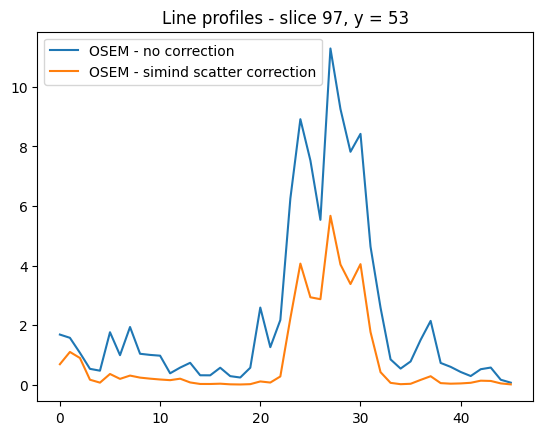

In [42]:
# line profiles
plt.plot(osem_reconstruction.as_array()[slice, 53, 50:96], label="OSEM - no correction")
plt.plot(osem_reconstruction_with_simind_scatter_correction.as_array()[slice, 53, 50:96], label="OSEM - simind scatter correction")
plt.title("Line profiles - slice 97, y = 53")
plt.legend()
plt.show()

In [25]:
# some functions for calculating metrics

def sphere_mask(arr_shape, center, radius):
    z, y, x = np.ogrid[:arr_shape[0], :arr_shape[1], :arr_shape[2]]
    dist_sq = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2
    return dist_sq <= radius**2

def mean_activity_conc_in_sphere(arr, center, radius, voxel_size, calibration_factor):
    mask = sphere_mask(arr.shape, center, radius)
    mean_count_per_vox = np.mean(arr[mask])
    return mean_count_per_vox / ((voxel_size/10)**3) / calibration_factor

def total_activity_in_sphere(arr, center, radius, calibration_factor):
    mask = sphere_mask(arr.shape, center, radius)
    counts = np.sum(arr[mask])
    return counts / calibration_factor

def standard_deviation_in_sphere(arr, center, radius, voxel_size, calibration_factor):
    mask = sphere_mask(arr.shape, center, radius)
    std_count_per_vox = np.std(arr[mask])
    return std_count_per_vox / ((voxel_size/10)**3) / calibration_factor

def SNR(arr, center, radius, voxel_size, calibration_factor):
    signal = mean_activity_conc_in_sphere(arr, center, radius, voxel_size, calibration_factor)
    noise_std = standard_deviation_in_sphere(arr, center, radius, voxel_size, calibration_factor)
    return signal / noise_std

def CNR(arr, center_obj, radius_obj, center_bg, radius_bg, voxel_size, calibration_factor):
    signal_obj = mean_activity_conc_in_sphere(arr, center_obj, radius_obj, voxel_size, calibration_factor)
    signal_bg = mean_activity_conc_in_sphere(arr, center_bg, radius_bg, voxel_size, calibration_factor)
    noise_std_bg = standard_deviation_in_sphere(arr, center_bg, radius_bg, voxel_size, calibration_factor)
    return (signal_obj - signal_bg) / noise_std_bg

calibration_factor = 0.0472 # Counts per second per MBq = counts / acquisition time / activity
calibration_factor*= (time_per_projection * measured_data.dimensions()[2]) # counts per MBq
activity_concentration = 1.611 # MBq/ml
activity_concentraion_voxel = activity_concentration * template_image.voxel_sizes()[0] * template_image.voxel_sizes()[1] * template_image.voxel_sizes()[2] # MBq / voxel

radii_150percent = [r * 1.5 for r in radii] # to include spillout
radii_75percent = [r * 0.75 for r in radii]
radii_50percent = [r * 0.5 for r in radii]

centres_3d = [(slice, c[1]+30, c[0]+32) for c in centres] # centres for full 3D array
centre_bg_3d = (slice, centre_bg[1]+30, centre_bg[0]+32)

expected_sphere_activity = [activity_concentration * 4/3 * np.pi * (d/2/10)**3 for d in diams]

In [26]:
def calculate_metrics(arr, center, radius, voxel_sizes, calibration_factor, bg_center, bg_radius):
    voxel_volume = voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2] # ml
    voxel_size_mm = np.mean(voxel_sizes) # assuming voxels are approximately cubic
    
    total_activity = total_activity_in_sphere(arr, center, radius, calibration_factor)
    activity_conc = mean_activity_conc_in_sphere(arr, center, radius, voxel_size_mm, calibration_factor)
    snr = SNR(arr, center, radius, voxel_size_mm, calibration_factor)
    cnr = CNR(arr, center, radius, bg_center, bg_radius, voxel_size_mm, calibration_factor)
    
    return total_activity, activity_conc, snr, cnr


In [27]:
reconstructions = {
    'OSEM': osem_reconstruction.as_array(),
    'OSEM with Simind Scatter': osem_reconstruction_with_simind_scatter_correction.as_array(),
}

# Lists of metrics and radii
radii_list = [radii, radii_75percent, radii_50percent, radii_150percent]
radii_names = ["Original", "75%", "50%", "150%"]

# Initialize empty list for storing dataframes
dfs = []

# Iterate for each radii
for rad, rad_name in zip(radii_list, radii_names):
    
    # Create a temporary dictionary to build dataframe
    data = {}
    
    for recon_name, recon_data in reconstructions.items():
        
        # Check if rad_name is 150% for special case (only Total Activity)
        if rad_name == "150%":
            activity_list = [total_activity_in_sphere(recon_data, c, r, calibration_factor) for c, r in zip(centres_3d, rad)]
            data[recon_name] = activity_list
        else:
            activity_concentration_list = []
            snr_list = []
            cnr_list = []

            for c, r in zip(centres_3d, rad):
                activity_concentration = mean_activity_conc_in_sphere(recon_data, c, r, template_image.voxel_sizes()[0], calibration_factor)
                snr = activity_concentration / standard_deviation_in_sphere(recon_data, c, r, template_image.voxel_sizes()[0], calibration_factor)
                
                bg_std = standard_deviation_in_sphere(recon_data, centre_bg_3d, r, template_image.voxel_sizes()[0], calibration_factor)
                cnr = (activity_concentration - mean_activity_conc_in_sphere(recon_data, centre_bg_3d, r, template_image.voxel_sizes()[0], calibration_factor)) / bg_std
                
                activity_concentration_list.append(activity_concentration)
                snr_list.append(snr)
                cnr_list.append(cnr)

            # We store each metric as a separate column in the dictionary
            data[f"{recon_name} - Activity Concentration"] = activity_concentration_list
            data[f"{recon_name} - SNR"] = snr_list
            data[f"{recon_name} - CNR"] = cnr_list

    # Convert dictionary to DataFrame with sphere diameters as the index and append to list
    df = pd.DataFrame(data, index=diams)  # Set sphere diameters as the index
    df.index.name = "NEMA sphere diameter"  # Set the index title
    dfs.append(df)

# At this point, dfs contains the four DataFrames. You can access each one by indexing the list.
original_df, seventy_five_df, fifty_df, one_fifty_df = dfs


/home/sam/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/sam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/sam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
one_fifty_df

,OSEM,OSEM with Simind Scatter
NEMA sphere diameter,,
37,1.562946,0.253678
28,4.520118,1.476526
22,0.336522,0.029531
17,0.066869,0.016679
13,0.056865,0.018082
11,0.042243,0.009067


In [29]:
original_df

,OSEM - Activity Concentration,OSEM - SNR,OSEM - CNR,OSEM with Simind Scatter - Activity Concentration,OSEM with Simind Scatter - SNR,OSEM with Simind Scatter - CNR
NEMA sphere diameter,,,,,,
37,0.015718,1.270059,-0.789743,0.003296,0.801625,-0.230645
28,0.122726,1.313022,1.664069,0.030733,0.573765,2.918640
22,0.020387,1.475026,-0.683754,0.001332,0.796874,-0.111276
17,0.005507,0.863378,-1.440360,0.000667,0.784145,-0.297081
13,0.016393,2.281573,-0.872516,0.003620,1.980363,5.841343
11,0.029181,1.168218,-0.377522,0.005437,0.948952,9.470737


In [30]:
seventy_five_df

,OSEM - Activity Concentration,OSEM - SNR,OSEM - CNR,OSEM with Simind Scatter - Activity Concentration,OSEM with Simind Scatter - SNR,OSEM with Simind Scatter - CNR
NEMA sphere diameter,,,,,,
37,0.016510,1.590940,-0.755227,0.003279,0.919226,-0.066336
28,0.114884,1.381200,2.474698,0.020566,0.563368,4.172133
22,0.018045,1.514079,-0.967728,0.001255,0.704192,0.543971
17,0.005074,0.942458,-1.310683,0.000580,0.952866,-0.231179
13,0.017630,2.100160,-2.392202,0.002623,8.357766,4.130664
11,0.026763,1.388602,-1.911062,0.007331,1.058476,17.544475


In [31]:
fifty_df

,OSEM - Activity Concentration,OSEM - SNR,OSEM - CNR,OSEM with Simind Scatter - Activity Concentration,OSEM with Simind Scatter - SNR,OSEM with Simind Scatter - CNR
NEMA sphere diameter,,,,,,
37,0.017297,1.832547,-0.951682,0.002748,1.186376,0.578175
28,0.114101,1.891380,3.643239,0.013602,0.690023,18.994214
22,0.014517,2.045184,-0.945156,0.000646,1.649220,-0.098050
17,0.001237,4.605658,-3.255744,0.000174,6.229732,-2.846701
13,0.017630,2.100160,-2.392202,0.002623,8.357766,4.130664
11,NaN,NaN,NaN,NaN,NaN,NaN
